In [40]:
import numpy as np
from scipy.optimize import linprog
from scipy.sparse.linalg import spsolve
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading the data from the data file. 

In [3]:
data_path = "/content/drive/MyDrive/Colab Notebooks/project2/data_set.data"

In [4]:

headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
          "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
          "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
          "peak-rpm","city-mpg","highway-mpg","price"]

df = pd.read_csv(data_path, names = headers)
df.shape

(204, 26)

In [5]:
pd.set_option('display.max_rows', 10,'display.max_columns',None)
df.head(204)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
200,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
201,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
202,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


# Data Cleaning

##  Converting '?' to NaN

*Some attributes have some missing elements in some instances , so the uknown values '?' is replaced by NaN*

In [6]:
pd.set_option('display.max_rows',20)
df.replace('?',np.nan,inplace=True)
miss_data=df.isnull()
display(miss_data.sum())
miss_data_col=["normalized-losses","bore","stroke","horsepower","peak-rpm","price"]
for c in miss_data_col:
    avg=df[c].astype("float").mean(axis=0)
    df[c].replace(np.nan,avg,inplace=True)
pd.set_option('display.max_rows', 10,'display.max_columns', None)
display(df)

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
                     ..
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
Length: 26, dtype: int64

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,121.718,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,121.718,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,121.718,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
200,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
201,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
202,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


##  Missing data 

In [33]:
miss_data=df.isnull()
display(miss_data.sum())

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
                    ..
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
Length: 26, dtype: int64

*We can see from the above list the attributes having missing data values:*
* *normalized-losses: **41** missing data values*
* *num-of-doors:**2** missing data values*
* *bore:**4** missing data values*
* *stroke:**4** missing data values*
* *horsepower:**2** missing data values*
* *peak-rpm:**2** missing data values*
* *price:**4** missing data values*

## Treating Missing Values

**Missing data was replaced by mean of group for continous and mode of group for categorical variables.**

In [7]:
df["num-of-doors"].replace(np.nan,df["num-of-doors"].value_counts().idxmax(),inplace =True ) 
print(df.isnull().sum())
df[["bore"]] = df[["bore"]].astype("float")
df[["stroke"]] = df[["stroke"]].astype("float")
df[["normalized-losses"]] = df[["normalized-losses"]].astype("int")
df[["price"]] = df[["price"]].astype("float")
df[["peak-rpm"]] = df[["peak-rpm"]].astype("float")
df[["horsepower"]] = df[["horsepower"]].astype("float")
df.info()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
                    ..
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
Length: 26, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          204 non-null    int64  
 1   normalized-losses  204 non-null    int64  
 2   make               204 non-null    object 
 3   fuel-type          204 non-null    object 
 4   aspiration         204 non-null    object 
 5   num-of-doors       204 non-null    object 
 6   body-style         204 non-null    object 
 7   drive-wheels       204 non-null    object 
 8   engine-location    204 non-null    object 
 9   wheel-base         204 non-null    float64
 10  length             204 non-null    f

# Converting categorical data values into numericals 

In [8]:
df["num-of-doors"] = df["num-of-doors"].apply(lambda x: 4 if x == 'four' else 2)
df.replace({'four': 4,'six': 6, 'five': 5, 'three': 3, 'twelve': 12, 'two': 2, 'eight': 8},inplace=True)


# Converting string to integer

In [9]:
for i in ['make','fuel-type','aspiration','body-style','drive-wheels','engine-location','engine-type','fuel-system']:
  codes=None
  unique=None
  #dict_+i = {unique, }
  codes, uniques = pd.factorize(df[i])
  df[i]=codes

In [10]:
display(df)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,121,0,0,0,2,0,0,0,88.6,168.8,64.1,48.8,2548,0,4,130,0,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121,0,0,0,2,0,0,0,88.6,168.8,64.1,48.8,2548,0,4,130,0,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121,0,0,0,2,1,0,0,94.5,171.2,65.5,52.4,2823,1,6,152,0,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164,1,0,0,4,2,1,0,99.8,176.6,66.2,54.3,2337,2,4,109,0,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164,1,0,0,4,2,2,0,99.4,176.6,66.4,54.3,2824,2,5,136,0,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-1,95,21,0,0,4,2,0,0,109.1,188.8,68.9,55.5,2952,2,4,141,0,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0
200,-1,95,21,0,1,4,2,0,0,109.1,188.8,68.8,55.5,3049,2,4,141,0,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0
201,-1,95,21,0,0,4,2,0,0,109.1,188.8,68.9,55.5,3012,1,6,173,0,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0
202,-1,95,21,1,1,4,2,0,0,109.1,188.8,68.9,55.5,3217,2,6,145,6,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0


In [31]:
df=df.astype("float")
y = df['symboling'].copy()
X = df.drop('symboling', axis=1).copy()
scaler = StandardScaler()
X = scaler.fit_transform(X)
trainX, testX, trainy, testy = train_test_split(X, y, train_size=0.8, random_state=100)

# Define model,Compile it ,fit it and evaluate


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Train: 0.325, Test: 0.341


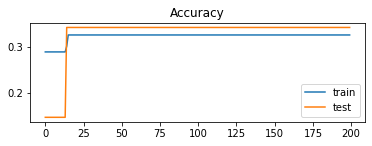

In [32]:
model = Sequential()
model.add(Dense(200, input_dim=25, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='softmax'))
# compile model
opt = SGD(lr=0.3, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


# L1 regularizer

In [36]:
yl = df['symboling'].copy()
Xl = df.drop('symboling', axis = 1).copy()
Xl = scaler.fit_transform(Xl)
trainXl, testXl, trainyl, testyl = train_test_split(Xl, yl, train_size = 0.8, random_state = 100)

In [39]:
# Defining the model
model = Sequential()
model.add(Dense(100, input_dim = 25, activation='relu', kernel_initializer='he_uniform', kernel_regularizer = tf.keras.regularizers.l1(0.001)))
model.add(Dense(1, activation='softmax', kernel_regularizer = tf.keras.regularizers.l1(0.000001)))

# Compiling the model
opt = SGD(learning_rate = 0.3, momentum = 0.9)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

history = model.fit(trainXl, trainyl, validation_data=(testXl, testyl), epochs = 200, verbose = 0)

# Evaluating the model
_, train_acc = model.evaluate(trainXl, trainyl, verbose = 0)
_, test_acc = model.evaluate(testXl, testyl, verbose = 0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.325, Test: 0.341
